https://realpython.com/python-keras-text-classification/

Check this out


# Using NLP to newsgroup documents classification

We'll compare Naive Bayes and Deep Learning models used for the classification of [newsgroup texts](http://qwone.com/~jason/20Newsgroups/). 

What we'll be doing: 
1. Multinomial Naive Bayes model
2. Deep Learning model
3. Deep Learning model with pre-trained embedded layer

We'll also check the accuracy of the models and some other metrics as well as ploting a confusion matrix.


# Multinomial Naive Bayes

## Import Libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

## Load the Dataset

In [ ]:
# load dataset
twenty = datasets.fetch_20newsgroups(shuffle = False)

In [ ]:
# display labels
for trg, trg_name in zip(set(twenty.target), twenty.target_names):
    print(f"{trg}  ==>  {trg_name}")

0  ==>  alt.atheism
1  ==>  comp.graphics
2  ==>  comp.os.ms-windows.misc
3  ==>  comp.sys.ibm.pc.hardware
4  ==>  comp.sys.mac.hardware
5  ==>  comp.windows.x
6  ==>  misc.forsale
7  ==>  rec.autos
8  ==>  rec.motorcycles
9  ==>  rec.sport.baseball
10  ==>  rec.sport.hockey
11  ==>  sci.crypt
12  ==>  sci.electronics
13  ==>  sci.med
14  ==>  sci.space
15  ==>  soc.religion.christian
16  ==>  talk.politics.guns
17  ==>  talk.politics.mideast
18  ==>  talk.politics.misc
19  ==>  talk.religion.misc


## Transform Data

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(twenty.data, twenty.target, test_size=0.3, random_state=10)

In [ ]:
print(len(X_train))
print(len(X_test))

7919
3395


In [ ]:
i = 4
print(f"Target: {y_train[i]} ==> {twenty.target_names[y_train[i]]}")
print('-------------------------------------------------------------')
print(X_train[i])

Target: 3 ==> comp.sys.ibm.pc.hardware
-------------------------------------------------------------
From: spring@diku.dk (Jesper Honig Spring)
Subject: COMPAQ and standard SIMM RAM (HELP)
Organization: Department of Computer Science, U of Copenhagen
Lines: 19


Hello,


Can anyone out there tell me if it is possible to put ordinary standard
SIMM RAM chips (70 ns) in a COMPAQ PROLINEA 4/50 or do COMPAQ require 
special COMPAQ RAM chips. 

Please (also) email me.


Thanks in advance.

Jesper
-- 
-------------------------------------------------------------------------------
jesper honig spring, spring@diku.dk |        IF ANIMALS BELIEVED IN GOD       
university of copenhagen, denmark   |         THE DEVIL WOULD BE A MAN
-------------------------------------------------------------------------------



In [ ]:
# english stop words
stop_words = frozenset(["'d", "'ll", "'re", "'s", "'ve", 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 
'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'could', 'did', 'do', 'does', 'doing', 'don', 'down', 
'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 
'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'it', "it's", 
'its', 'itself', 'just', "let's", 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 
'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same', 'she', "she'd", "she'll", "she's", 'should', 'so', 
'some', 'such', 't', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 
'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 
'we', "we'd", "we'll", "we're", "we've", 'were', 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', 
"who's", 'whom', 'why', "why's", 'will', 'with', 'would', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])

In [ ]:
def transform_sentences(sentences_array, stop_words):
    # transforms the sentences removing: 
    # stop_words, multiple blank spaces and e-mail addresses
    tmp = ""
    sentences = []
    for sentence in sentences_array:
        # to lower case
        tmp = sentence.lower()
        # remove email addresses
        tmp = re.sub(r"\S*@\S*", " ", tmp)
        # remove e-mail common words
        tmp = tmp.replace("from:", "")
        tmp = tmp.replace("re:", "")
        tmp = tmp.replace("subject:", "")
        tmp = tmp.replace("lines:", "")
        tmp = tmp.replace("organization:", "")
        # remove single chars on the text
        tmp = re.sub(rf"(\W)\w(\W)", " ", tmp)

        # for each stop_word
        for stop_word in stop_words:
            # remove stop word
            tmp = re.sub(rf"(\W){stop_word}(\W)", " ", tmp)

        # convert multiple spaces to single ones
        tmp = re.sub(r"\s+", " ", tmp)
        # append result to sentences
        sentences.append(tmp)
    return sentences

In [ ]:
# pre-process the training and testing set
X_train = transform_sentences(X_train, stop_words=stop_words)
X_test = transform_sentences(X_test, stop_words=stop_words)

In [ ]:
# Pipeline: vectorizer => transformer
text_clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer())
])

In [ ]:
# prepare the data to input the model
X_train_tf = text_clf.fit_transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let', 'll', 're', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
print(X_train_tf.shape)
print(f"There are {X_train_tf.shape[0]} sentences in the training set.")
print(f"There are {X_train_tf.shape[1]} unique words in the training set.")

(7919, 86878)
There are 7919 sentences in the training set.
There are 86878 unique words in the training set.


## Create the model

In [ ]:
# create and fit the Multinomial Naive Bayes model
model = MultinomialNB().fit(X_train_tf, y_train)

In [ ]:
# transform the test dataset
X_test_tf = text_clf.transform(X_test)

# predict
y_hat = model.predict(X_test_tf)

In [ ]:
i = 0
print(f"Predicted: {y_hat[i]} ==> {twenty.target_names[y_hat[i]]}")
print(f"Original : {y_test[i]} ==> {twenty.target_names[y_test[i]]}")
print("--------------------------------------------------------------")
print(X_test[i])

Predicted: 11 ==> sci.crypt
Original : 11 ==> sci.crypt
--------------------------------------------------------------
 (rob defriesse) des code shipped canada? article d.: fripp.1993apr22.125402.27561 reply cadre technologies inc. 13 nntp-posting-host: 192 200.19 someone canada asked send public domain des file encryption code legal send thanx. -- eschew obfuscation rob defriesse mail: cadre technologies inc. phone: (401) 351-5950 222 richmond st. fax: (401) 351-7380 providence, ri 02903 speak employer. 


## Make predictions on new data

In [ ]:
# custom phrases
docs_new = ['God is love', 
            'OpenGL on the GPU is fast', 
            "You can not go on without our new product. There's a promotion for you right now!!", 
            'You should read the BIBLE! It is the greatest book of all time.']

X_new_tfidf = text_clf.transform(docs_new)

predicted = model.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print(f'{doc} => {twenty.target_names[category]}')

God is love => soc.religion.christian
OpenGL on the GPU is fast => rec.autos
You can not go on without our new product. There's a promotion for you right now!! => sci.crypt
You should read the BIBLE! It is the greatest book of all time. => soc.religion.christian


## Model Performance

In [ ]:
# check if the model performs well on unseen data
accuracy_score = accuracy_score(y_test, y_hat)
print(accuracy_score)

0.8674521354933726


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_hat)

In [ ]:
# text report showing the main classification metrics
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.89      0.77      0.82       149
           1       0.94      0.75      0.84       196
           2       0.77      0.90      0.83       156
           3       0.73      0.86      0.79       161
           4       0.93      0.88      0.90       172
           5       0.93      0.86      0.89       175
           6       0.83      0.85      0.84       149
           7       0.87      0.93      0.90       168
           8       0.97      0.93      0.95       181
           9       0.98      0.97      0.98       193
          10       0.95      0.98      0.97       189
          11       0.76      0.98      0.85       171
          12       0.92      0.77      0.84       184
          13       0.96      0.97      0.97       164
          14       0.88      0.98      0.93       167
          15       0.67      0.97      0.79       197
          16       0.85      0.96      0.90       174
          17       0.90    

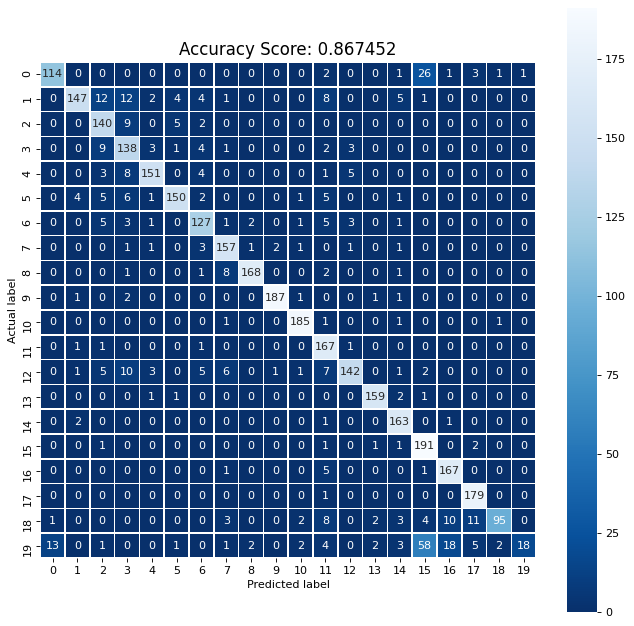

In [ ]:
# plot the confusion matrix
plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 80})
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:f}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

# Using Tensorflow and Keras

## Import Libs

In [ ]:
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from math import floor

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import datasets
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

In [ ]:
# load the dataset
twenty = datasets.fetch_20newsgroups(shuffle = False)

In [ ]:
# display the labels
for trg, trg_name in zip(set(twenty.target), twenty.target_names):
    print(f"{trg}  ==>  {trg_name}")

0  ==>  alt.atheism
1  ==>  comp.graphics
2  ==>  comp.os.ms-windows.misc
3  ==>  comp.sys.ibm.pc.hardware
4  ==>  comp.sys.mac.hardware
5  ==>  comp.windows.x
6  ==>  misc.forsale
7  ==>  rec.autos
8  ==>  rec.motorcycles
9  ==>  rec.sport.baseball
10  ==>  rec.sport.hockey
11  ==>  sci.crypt
12  ==>  sci.electronics
13  ==>  sci.med
14  ==>  sci.space
15  ==>  soc.religion.christian
16  ==>  talk.politics.guns
17  ==>  talk.politics.mideast
18  ==>  talk.politics.misc
19  ==>  talk.religion.misc


## Transform Data

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(twenty.data, twenty.target, test_size=0.15, random_state=10)

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=10)

In [ ]:
# size of train, test and validation datasets
print(len(X_train))
print(len(y_val))
print(len(X_test))

8654
962
1698


In [ ]:
i = 4
print(f"Target: {y_train[i]} ==> {twenty.target_names[y_train[i]]}")
print('-------------------------------------------------------------')
print(X_train[i])

Target: 1 ==> comp.graphics
-------------------------------------------------------------
Organization: City University of New York
From: <NT3QC@CUNYVM.BITNET>
Subject: RE: Hot new 3D software
Lines: 16

I don't think speed has been determined, since it has never run on Intel chips.
But on the Amiga's Motorola Chips, it was one of the fastest true 'Ray Tracers'

I don't think Impulse would port it over and not take speed into consideration.

In terms of features, and learning curve... ALL that you stated for 3DS is also
true for Imagine, and lots more... But I'll have to admit that after 3 years of
use on the Amiga, the learning curve is very steep. This is due ONLY to the
manual. It is realy BAD. However, there is a lot of after market support for
this product, including regular 'Tips' articles in many magazines such as "AVID
and a great book by Steve Worley called "Understanding Imagine 2.0" This book i
is not just recommened, IT IS A MUST!

I think an important consideration should 

In [ ]:
# english stop words
stop_words = frozenset(["'d", "'ll", "'re", "'s", "'ve", 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 
'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'could', 'did', 'do', 'does', 'doing', 'don', 'down', 
'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 
'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'it', "it's", 
'its', 'itself', 'just', "let's", 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 
'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same', 'she', "she'd", "she'll", "she's", 'should', 'so', 
'some', 'such', 't', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 
'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 
'we', "we'd", "we'll", "we're", "we've", 'were', 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', 
"who's", 'whom', 'why', "why's", 'will', 'with', 'would', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])

In [ ]:
# take a look at our data
print(X_train[0])

From: glover@tafs2.mitre.org (Graham K. Glover)
Subject: The Cold War: Who REALLY Won?
Nntp-Posting-Host: gglover-mac.mitre.org
Organization: The MITRE Corporation, McLean, VA
Lines: 13

If one reasons that the United States of America at one time represented 
and protected freedom << individual liberty and personal responsibility >> 
(and I do, in fact, think that this is true) and that totalitarianism << 
absolute government control and tyranny >> represents freedom's opposite 
(which it does), did the USA really win the cold war?

Standard disclaimers ALWAYS apply!

----------------
Graham K. Glover
----------------

UNMUTUAL



In [ ]:
def transform_sentences(sentences_array, stop_words):
    # transforms the sentences removing: 
    # stop_words, multiple blank spaces and e-mail addresses
    tmp = ""
    sentences = []
    for sentence in sentences_array:
        # to lower case
        tmp = sentence.lower()
        # remove email addresses
        tmp = re.sub(r"\S*@\S*", " ", tmp)
        # remove e-mail common words
        tmp = tmp.replace("from:", "")
        tmp = tmp.replace("re:", "")
        tmp = tmp.replace("subject:", "")
        tmp = tmp.replace("lines:", "")
        tmp = tmp.replace("organization:", "")
        # remove single chars on the text
        tmp = re.sub(rf"(\W)\w(\W)", " ", tmp)

        # for each stop_word
        for stop_word in stop_words:
            # remove stop word
            tmp = re.sub(rf"(\W){stop_word}(\W)", " ", tmp)

        # convert multiple spaces to single ones
        tmp = re.sub(r"\s+", " ", tmp)
        # append result to sentences
        sentences.append(tmp)
    return sentences

In [ ]:
# pre-process the training and testing set
X_train = transform_sentences(X_train, stop_words=stop_words)
X_val = transform_sentences(X_val, stop_words=stop_words)
X_test = transform_sentences(X_test, stop_words=stop_words)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

8654
962
1698


In [ ]:
i = 0
print(X_train[i])

 (graham glover) cold war: really won? nntp-posting-host: gglover-mac.mitre.org mitre corporation, mclean, va 13 one reasons united states america one time represented protected freedom << individual liberty personal responsibility >> fact, think true) totalitarianism << absolute government control tyranny >> represents freedom opposite , usa really win cold war? standard disclaimers always apply! ---------------- graham glover ---------------- unmutual 


In [ ]:
count_word = 0
for sentence in X_train:
    # count the words on training set
    count_word += len(sentence.split())

# mean number of words on training set
max_words = floor(count_word/len(X_train))
print(f"max_words in the model: {max_words}")

# the maximum number of words to keep, based on word frequency
# Only the most common `num_words-1` words will be kept
vocab_size = 20000
# number of dimentions on the embedding layer
embedding_dim = 16
# truncating type of the sentences
trunc_type='post'
# padding type of sequences of words
padding_type='post'
# out-of-value token
oov_tok = "<OOV>"

max_words in the model: 164


In [ ]:
# vectorize a text corpus, by turning each text into a sequence of 
# integers (each integer being the index of a token in a dictionary)
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
# top 20 words and it's tokens
i=0
for word in word_index:
    print(f"{word} : {word_index[word]}")
    i+=1
    if i==20: 
        break

<OOV> : 1
'ax : 2
one : 3
writes : 4
' : 5
article : 6
people : 7
like : 8
university : 9
posting : 10
know : 11
host : 12
get : 13
max : 14
nntp : 15
m : 16
think : 17
also : 18
use : 19
new : 20


In [ ]:
print(f"Total of tokens: {len(word_index)}")

Total of tokens: 89357


In [ ]:
# Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(len(train_sequences))
print(train_sequences[0])

8654
[2416, 19129, 1669, 431, 56, 247, 15, 10, 12, 1, 272, 4897, 2073, 4897, 653, 7770, 1616, 214, 3, 975, 785, 369, 949, 3, 21, 6975, 2260, 932, 903, 2953, 678, 1591, 137, 17, 125, 1, 1716, 83, 236, 8838, 3041, 932, 3042, 84, 56, 287, 1669, 431, 305, 3810, 248, 1210, 2416, 19129, 1]


In [ ]:
# Pads sequences to the same length. (required to input the model)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_words)
val_padded = pad_sequences(val_sequences, padding=padding_type, maxlen=max_words)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_words)

In [ ]:
print(len(train_padded))
print(train_padded[0])

8654
[ 2416 19129  1669   431    56   247    15    10    12     1   272  4897
  2073  4897   653  7770  1616   214     3   975   785   369   949     3
    21  6975  2260   932   903  2953   678  1591   137    17   125     1
  1716    83   236  8838  3041   932  3042    84    56   287  1669   431
   305  3810   248  1210  2416 19129     1     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

In [ ]:
# inserts a dimension of size 1 at the end of the array (required shape to fit the keras model training)
y_train = tf.expand_dims(y_train, -1)
y_val = tf.expand_dims(y_val, -1)
y_test = tf.expand_dims(y_test, -1)

In [ ]:
print(train_padded.shape)
print(y_train.shape)

print(val_padded.shape)
print(y_val.shape)

print(test_padded.shape)
print(y_test.shape)

(8654, 164)
(8654, 1)
(962, 164)
(962, 1)
(1698, 164)
(1698, 1)


## Create the model

In [ ]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 164, 16)           320000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 164, 16)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 160, 128)          10368     
_________________________________________________________________
global_average_pooling1d_29  (None, 128)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)             

In [ ]:
num_epochs = 40
history = model.fit(train_padded, y_train, epochs=num_epochs, 
                    validation_data=(val_padded, y_val), verbose=2)

Epoch 1/40
271/271 - 3s - loss: 2.7875 - accuracy: 0.0937 - val_loss: 2.3589 - val_accuracy: 0.1861
Epoch 2/40
271/271 - 3s - loss: 2.2230 - accuracy: 0.1992 - val_loss: 1.9670 - val_accuracy: 0.3472
Epoch 3/40
271/271 - 3s - loss: 1.7697 - accuracy: 0.3453 - val_loss: 1.4975 - val_accuracy: 0.5031
Epoch 4/40
271/271 - 3s - loss: 1.3226 - accuracy: 0.5225 - val_loss: 1.1460 - val_accuracy: 0.6518
Epoch 5/40
271/271 - 2s - loss: 0.9732 - accuracy: 0.6578 - val_loss: 0.9721 - val_accuracy: 0.6954
Epoch 6/40
271/271 - 3s - loss: 0.7452 - accuracy: 0.7490 - val_loss: 0.8645 - val_accuracy: 0.7453
Epoch 7/40
271/271 - 3s - loss: 0.5763 - accuracy: 0.8121 - val_loss: 0.8605 - val_accuracy: 0.7547
Epoch 8/40
271/271 - 3s - loss: 0.4485 - accuracy: 0.8545 - val_loss: 0.8480 - val_accuracy: 0.7807
Epoch 9/40
271/271 - 3s - loss: 0.3813 - accuracy: 0.8825 - val_loss: 0.8804 - val_accuracy: 0.7713
Epoch 10/40
271/271 - 2s - loss: 0.3105 - accuracy: 0.9040 - val_loss: 0.9005 - val_accuracy: 0.7879

## Check how the model performs

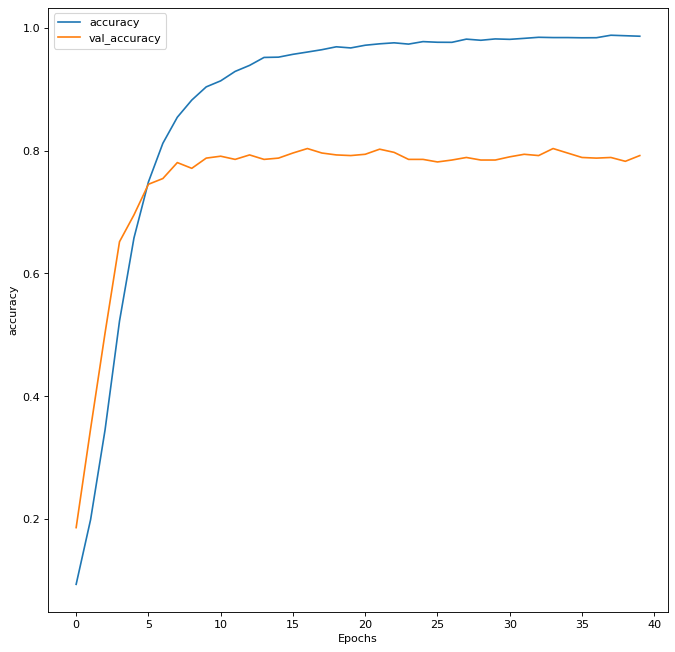

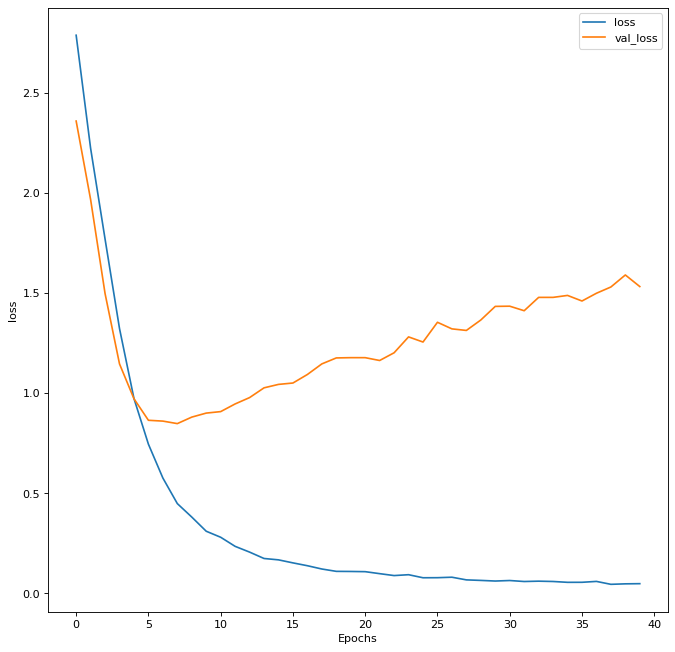

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# make prediction on the test dataset
y_hat = model.predict(test_padded)

In [ ]:
print(y_hat.shape)
print(y_test.shape)

(1698, 20)
(1698, 1)


In [ ]:
# result of softmax output layer (probabilities)
y_hat[0]

array([8.13644013e-11, 2.52522051e-01, 4.25022226e-05, 4.70035288e-10,
       8.98344332e-09, 1.22294425e-10, 8.65720115e-18, 2.42283822e-16,
       8.55790092e-12, 1.94225753e-13, 1.13482906e-13, 7.43737459e-01,
       6.26668480e-05, 2.78507615e-03, 7.07581115e-04, 5.72950411e-12,
       3.55332418e-07, 5.80143169e-05, 8.42650697e-05, 1.34926662e-12],
      dtype=float32)

In [ ]:
# transform the softmax output to sparse categorical
y_hat = tf.argmax(y_hat, axis=1)
y_hat = tf.expand_dims(y_hat, -1)

In [ ]:
print(y_hat.shape)
print(y_hat[0])
print(y_hat)
print('-----------------------------------------------------------------------')

print(y_test.shape)
print(y_test[0])
print(y_test)

(1698, 1)
tf.Tensor([11], shape=(1,), dtype=int64)
tf.Tensor(
[[11]
 [ 5]
 [ 0]
 ...
 [ 6]
 [ 8]
 [ 8]], shape=(1698, 1), dtype=int64)
-----------------------------------------------------------------------
(1698, 1)
tf.Tensor([11], shape=(1,), dtype=int64)
tf.Tensor(
[[11]
 [19]
 [16]
 ...
 [ 6]
 [ 8]
 [ 8]], shape=(1698, 1), dtype=int64)


In [ ]:
# check if the model performs well on unseen data
accuracy_score = sk.metrics.accuracy_score(y_test, y_hat)
print(accuracy_score)

0.7997644287396938


## Let's try using adding an already trained embedded layer

In [ ]:
# we'll use a 100 dimension pre trained embedded layer 
embedding_dim = 100

# Note this is the 100 dimension version of GloVe from Stanford
# Already unzipped and hosted on laurence moroney site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

--2020-07-24 14:56:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   153MB/s    in 2.2s    

2020-07-24 14:56:22 (153 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
print(len(embeddings_index))
print(embeddings_index['fell'])

400000
[ 1.1723    0.47077   0.24895   0.34277   0.15616  -0.64096   0.29827
 -0.41819  -0.35123  -0.45461   0.64912   0.21499  -0.12391  -0.24777
  0.75844  -0.66743  -0.84218   0.1259   -0.033644  0.18011   1.4764
  0.11518   0.75285   1.3225    0.52252  -0.36595  -0.38948  -0.35271
 -0.078046 -0.18693   0.28865  -0.32948  -0.16373   0.066645 -0.31936
  0.78904   0.51626  -0.17687   0.32629  -0.1747   -0.057353 -0.73643
 -0.14736  -0.50068   0.1074    0.40757  -0.035597  0.80876   0.38344
 -1.6169   -0.022249 -0.041174  0.43792   1.4448   -0.36316  -1.8444
 -0.92259   0.11691   1.7746    1.1205    0.48343  -0.25156  -0.7128
  0.5216   -0.72338   0.12475   0.21331   0.4404    0.65213   0.34467
 -0.60703   0.32183   0.13004   0.4413   -0.43109  -0.08948  -0.56405
  0.58261  -0.71475   0.35147   0.23263   0.88021  -0.57649  -0.11717
 -0.92284  -0.988    -0.090227 -0.072176  0.49901   0.79342   0.23638
  0.074772 -0.2732    0.475    -1.2078    0.53425   0.58641   0.070467
  0.096335 -0.2

In [ ]:
# there are more words on the 'word_index' than our desired vocabulary size
# The Tokenizer stores everything in the word_index during fit_on_texts. 
# Then, when calling the texts_to_sequences method, only the top num_words are considered.
print(len(word_index))
#print(word_index)

89357


## Creating our embedded layer

In [ ]:
# create an embedding matrix for the first 'vocab_size' words
# on the 'word_index' created by the Tokenizer
# 'vocab_size + 1' the 'plus one' is the zero used for the padding
# it's embedded values are all zeroes
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
wi_c = 0
for word, i in word_index.items():
    # stop after the number of words 'vocab_size'
    # the first value will not be iterated, thus it is zero
    if wi_c == vocab_size:
        break
    wi_c += 1

    # get only the needed words to the embedded layer
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;


In [ ]:
print(embeddings_matrix.shape)
print(embeddings_matrix)

(20001, 100)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 6.66700006e-01  4.27980006e-01  1.80710003e-01 ...  1.37889996e-01
  -1.14070000e-02 -7.40620017e-01]
 [-2.51549989e-01 -4.06970009e-02  5.60880005e-01 ... -8.91839992e-03
  -5.57090007e-02  5.29079974e-01]
 [-4.84600008e-01  4.18020010e-01  5.99720001e-01 ...  4.32740003e-01
   6.18770003e-01 -6.25170011e-04]]


## Create new model with pre-trained embedded layer

In [ ]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=train_padded.shape[1], weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 164, 100)          2000100   
_________________________________________________________________
dropout_41 (Dropout)         (None, 164, 100)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 160, 128)          64128     
_________________________________________________________________
global_average_pooling1d_33  (None, 128)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)             

In [ ]:
num_epochs = 150
history = model.fit(train_padded, y_train, epochs=num_epochs, 
                    validation_data=(val_padded, y_val), verbose=2)

Epoch 1/150
271/271 - 2s - loss: 2.2905 - accuracy: 0.2716 - val_loss: 1.5760 - val_accuracy: 0.5353
Epoch 2/150
271/271 - 2s - loss: 1.6597 - accuracy: 0.4508 - val_loss: 1.3418 - val_accuracy: 0.5852
Epoch 3/150
271/271 - 2s - loss: 1.4607 - accuracy: 0.5133 - val_loss: 1.2195 - val_accuracy: 0.6133
Epoch 4/150
271/271 - 2s - loss: 1.3505 - accuracy: 0.5488 - val_loss: 1.1510 - val_accuracy: 0.6518
Epoch 5/150
271/271 - 2s - loss: 1.2857 - accuracy: 0.5759 - val_loss: 1.0934 - val_accuracy: 0.6549
Epoch 6/150
271/271 - 2s - loss: 1.2233 - accuracy: 0.5941 - val_loss: 1.0556 - val_accuracy: 0.6590
Epoch 7/150
271/271 - 2s - loss: 1.1878 - accuracy: 0.6070 - val_loss: 1.0245 - val_accuracy: 0.6736
Epoch 8/150
271/271 - 2s - loss: 1.1477 - accuracy: 0.6212 - val_loss: 1.0089 - val_accuracy: 0.6881
Epoch 9/150
271/271 - 2s - loss: 1.1122 - accuracy: 0.6362 - val_loss: 0.9711 - val_accuracy: 0.6913
Epoch 10/150
271/271 - 2s - loss: 1.0821 - accuracy: 0.6455 - val_loss: 0.9491 - val_accura

## Check how the model performs

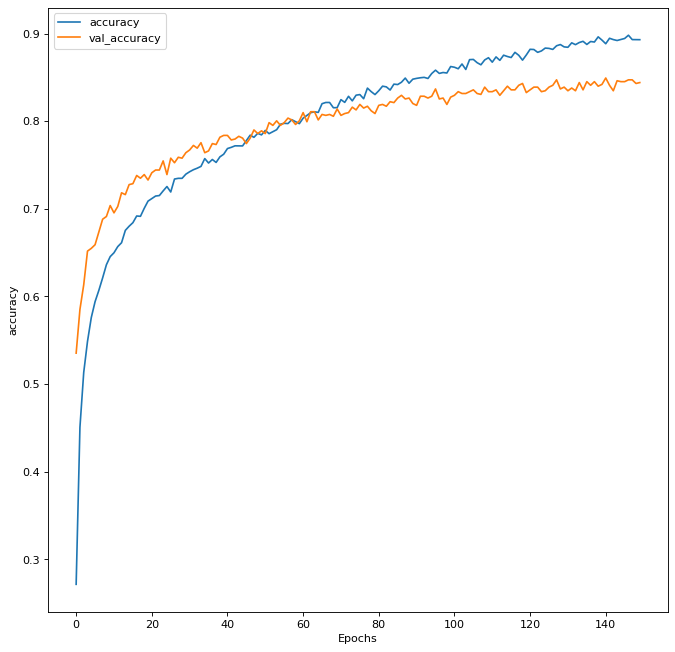

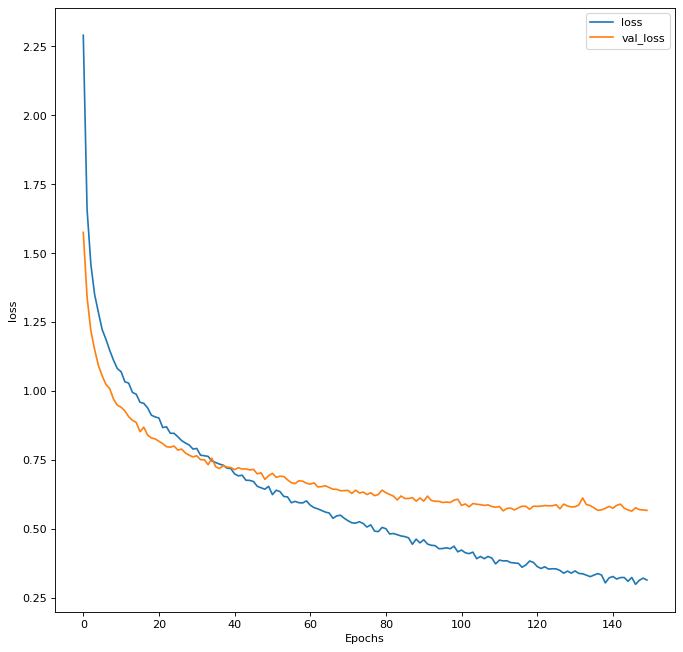

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# predict on test dataset
y_hat = model.predict(test_padded)

In [ ]:
print(y_hat.shape)
print(y_test.shape)

(1698, 20)
(1698, 1)


In [ ]:
# result of softmax output layer (probabilities)
y_hat[0]

array([6.2157380e-07, 3.6178266e-03, 1.8171255e-03, 2.0800896e-03,
       6.2363782e-05, 6.9949143e-03, 4.0384988e-05, 4.5608240e-06,
       1.5237625e-05, 5.7125595e-07, 2.4893725e-06, 9.8401654e-01,
       6.7503680e-04, 2.0626654e-05, 3.7990143e-05, 1.2252261e-08,
       5.6575873e-04, 8.5459033e-06, 1.4375124e-05, 2.4909272e-05],
      dtype=float32)

In [ ]:
# transform the softmax output to sparse categorical
y_hat = tf.argmax(y_hat, axis=1)
y_hat = tf.expand_dims(y_hat, -1)

In [ ]:
print(y_hat.shape)
print(y_hat[0])
print(y_hat)
print('-----------------------------------------------------------------------')

print(y_test.shape)
print(y_test[0])
print(y_test)

(1698, 1)
tf.Tensor([11], shape=(1,), dtype=int64)
tf.Tensor(
[[11]
 [ 6]
 [16]
 ...
 [ 6]
 [ 8]
 [ 8]], shape=(1698, 1), dtype=int64)
-----------------------------------------------------------------------
(1698, 1)
tf.Tensor([11], shape=(1,), dtype=int64)
tf.Tensor(
[[11]
 [19]
 [16]
 ...
 [ 6]
 [ 8]
 [ 8]], shape=(1698, 1), dtype=int64)


In [ ]:
# check if the model performs well on unseen data
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_hat)
print(acc_score)

0.8180212014134276


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_hat)

In [ ]:
# text report showing the main classification metrics
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        76
           1       0.76      0.86      0.80       105
           2       0.69      0.80      0.74        83
           3       0.59      0.72      0.65        81
           4       0.89      0.63      0.74        89
           5       0.72      0.71      0.72        84
           6       0.78      0.79      0.78        78
           7       0.75      0.91      0.83        70
           8       0.99      0.84      0.91        86
           9       0.94      0.93      0.93        96
          10       0.95      0.93      0.94        76
          11       0.90      0.89      0.89       100
          12       0.72      0.65      0.68        85
          13       0.90      0.93      0.92        82
          14       0.90      0.90      0.90        82
          15       0.80      0.88      0.84        97
          16       0.89      0.86      0.87        91
          17       0.89    

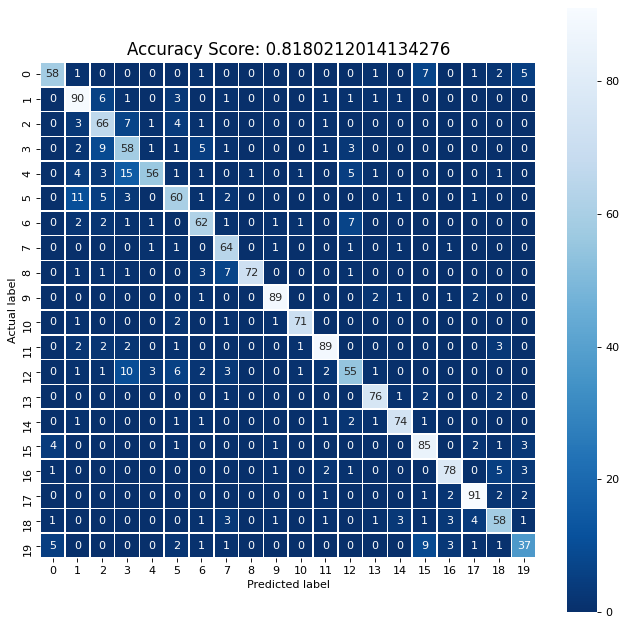

In [ ]:
# plot the confusion matrix
plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 80})
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {acc_score}'
plt.title(all_sample_title, size = 15);

## Quick test on new data

In [ ]:
# custom phrases
docs_new = ['God is love', 
            'OpenGL on the GPU is fast', 
            "You can not go on without our new product. There's a promotion for you right now!!", 
            'You should read the BIBLE! It is the greatest book of all time.']


# Transforms each text in texts to a sequence of integers.
docs_sequences = tokenizer.texts_to_sequences(docs_new)

# Pads sequences to the same length.
docs_padded = pad_sequences(docs_sequences, padding=padding_type, maxlen=max_words)

# make prediction on the new dataset
predicted = model.predict(docs_padded)

# transform the softmax output to sparse categorical
predicted = tf.argmax(predicted, axis=1)

for doc, category in zip(docs_new, predicted):
    print(f'{doc} => {twenty.target_names[category]}')

God is love => comp.windows.x
OpenGL on the GPU is fast => comp.windows.x
You can not go on without our new product. There's a promotion for you right now!! => comp.windows.x
You should read the BIBLE! It is the greatest book of all time. => comp.windows.x


# Conclusion

The Naive-Bayes model was very easy and quick to create and it performed very well even on our first try.

The Deep Learning model performed well too, nonetheless it wasn't the best performer model. Altough the accuracy of this model wasn't as good as the previous model, we could check that even when the prediction was not accurate, the wrong predictions were classified as to a class close to the correct answer. That's due to the power of the pre-trained embedding in NN that captures the relative fields in which the words are usually inserted into.

- The **Naive-Bayes is very quick to implement**. The model itself does not require tunning it's hiperparameters (not in most cases). On the other hand, **usually the data must be well pre-processed** before being fed to the model, in this case the pre-processing is very simple.

- The **Deep Learning model requires a lot of hiperparameter** tunning and also testing and **finding a proper model architecture** to perform better (was not the focus on this notebook). A bigger dataset always happen to help deep learning models as well. That would take a lot more of our time.


# References

- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)
- https://nlp.stanford.edu/projects/glove/
- https://www.tensorflow.org/tutorials/text/word_embeddings
- https://github.com/keras-team/keras/issues/7551
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
- https://scikit-learn.org/stable/modules/naive_bayes.html
- https://gist.github.com/sebleier/554280
- https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
- http://qwone.com/~jason/20Newsgroups/
